In [1]:
%load_ext autoreload
%autoreload 2

# Dataset

In [2]:
from torch_geometric.datasets import WordNet18RR

In [3]:
data_dir = 'data'
dataset = WordNet18RR(data_dir)
            

In [4]:
data = dataset.data
print('Number of nodes: {:,}'.format(data.num_nodes))
print('Number of edges: {:,}'.format(data.num_edges))

Number of nodes: 40,943
Number of edges: 93,003


In [5]:
import numpy as np
# number of unique relations (edge types)
num_relations = np.unique(data.edge_type).shape[0]
num_nodes = data.num_nodes
print('Number of relations: {:,}'.format(num_relations))
assert ((0 <= data.edge_type) & (data.edge_type < num_relations)).all(), 'edge_type must be in [0, num_relations)'
assert ((0 <= data.edge_index[0]) & (data.edge_index[0] < num_nodes)).all(), 'edge_index must be in [0, num_nodes)'
assert ((0 <= data.edge_index[1]) & (data.edge_index[1] < num_nodes)).all(), 'edge_index must be in [0, num_nodes)'

Number of relations: 11


In [6]:
from dataset import WN18RR, Triple

edge_index = data.edge_index.t()
edge_type = data.edge_type

train_mask = data.train_mask
test_mask = data.test_mask
val_mask = data.val_mask

triples = []
for i in range(len(edge_index)):
    head = edge_index[i][0]
    tail = edge_index[i][1]
    relation = edge_type[i]
    triples.append(Triple(head=head, tail=tail, relation=relation))



In [7]:
triples = np.array(triples)
train_triples, test_triples, val_triples = triples[train_mask], triples[test_mask], triples[val_mask]
train, test, val = WN18RR(train_triples), WN18RR(test_triples), WN18RR(val_triples)

# Model

In [11]:
import json
# Best hyperparameters on WordNet dataset according to the paper
with open('params.json', 'r', encoding='utf-16') as f:
    lines = f.readlines()
    params = json.loads(''.join(lines))

In [12]:
from model import TransE

transe = TransE(num_nodes, num_relations, params['emb_size'], params['margin'], params['p_norm'])

In [13]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train, batch_size=params["batch_size"], shuffle=True)
test_loader = DataLoader(test, batch_size=params["batch_size"], shuffle=False)
val_loader = DataLoader(val, batch_size=params["batch_size"], shuffle=True)

In [27]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, optimizer, num_epochs, eval_freq=1, scheduler=None):
    """
    Train model for num_epochs epochs.
    :param model: model to train
    :param train_loader: train data loader
    :param val_loader: validation data loader
    :param optimizer: optimizer
    :param num_epochs: number of epochs
    :param eval_freq: frequency of evaluation (in epochs)
    :param scheduler: learning rate scheduler
    """    
    train_history = []
    val_history = []
    for epoch in tqdm(range(num_epochs)):
        model.train() # Enter train mode
        
        loss_accum = 0
        for i_step, (h, r, t) in enumerate(train_loader):
            loss_value = model.loss(h, r, t)

            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            loss_accum += loss_value.item()

        if scheduler is not None:
            scheduler.step()

        
        if epoch % eval_freq == eval_freq - 1:
            model.eval() 
            with torch.no_grad():
                for (h, r, t) in train_loader:
                    train_history.append(model.loss(h, r, t).item())
                    break
                for (h, r, t) in val_loader:
                    val_history.append(model.loss(h, r, t).item())
                    break
            print(f"Epoch {epoch}\nTrain loss: {train_history[-1]:.4f}, Val loss: {val_history[-1]:.4f}")
        
    return train_history, val_history



In [29]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


optimizer = optim.Adam(transe.parameters(), lr=params['lr'])
scheduler = StepLR(optimizer, step_size=params['step_size'], gamma=params['gamma'])
train_history, val_history = train_model(transe, train_loader, val_loader, optimizer, params['num_epochs'], params['eval_freq'], scheduler=scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: expand(torch.LongTensor{[128, 128]}, size=[128]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

Text(0, 0.5, 'Loss')

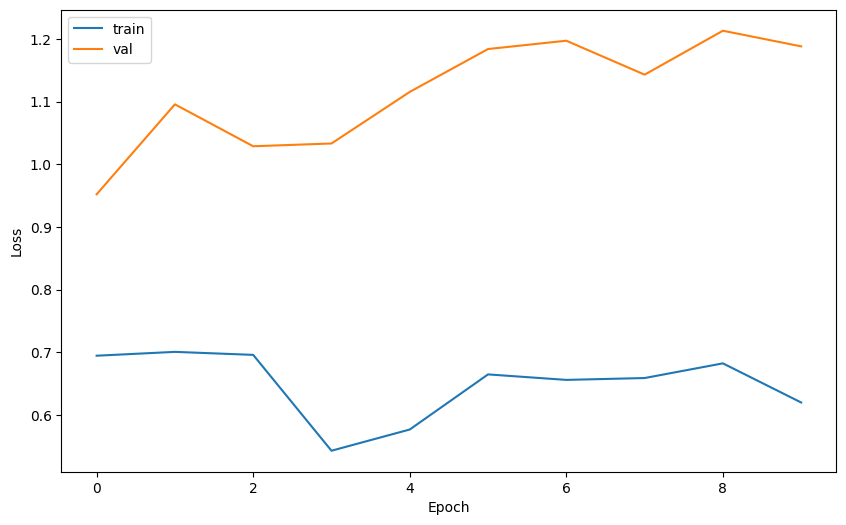

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# draw train and validation loss
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(train_history)), y=train_history, label='train')
sns.lineplot(x=range(len(val_history)), y=val_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [ ]:
test_tensor = torch.tensor(test[:]).t()
hits_at_10, mean_rank = transe.test(*test_tensor)
print(f"Hits@10: {hits_at_10:.4f}, Mean rank: {mean_rank}")

Hits@10: 0.0035, Mean rank: 21427.640625
